In [1]:
import sys
sys.path.append('../..')
import datetime
import pickle

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
    
path_to_save = '../../figures/'
path_save_pickled = '../../data/'
rerun = True

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
# date_data_end   = cov19.get_last_date(confirmed_cases)
date_data_end = datetime.datetime(2020,4,21)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 21
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

country = 'Germany'

cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_median_lambda = 1,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1)]

model = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                    N=83e6,
                                    priors_dict=None,
                                    with_random_walk=False,
                                    weekends_modulated=True,
                                    weekend_modulation_type = 'abs_sine')

if rerun:
    trace = pm.sample(model=model, init='advi+adapt_diag', draws=4000, tune=1000)

    pickle.dump([model, trace], open(path_save_pickled + 'SEIR.pickled', 'wb'))

else: 
    model, trace = pickle.load(open(path_save_pickled + 'SEIR.pickled', 'rb'))

INFO: This code is not longer developed, use our new module instead: github.com/Priesemann-Group/covid19_inference
pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_lambda_0 was set to default value 2
pr_sigma_lambda_0 was set to default value 0.7
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 w

In [7]:
exec(open('figures_revised.py').read())

additional insets: E_begin_scale
additional insets: median_incubation


/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2046: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1bcfc8d250>,
       dtype=object))

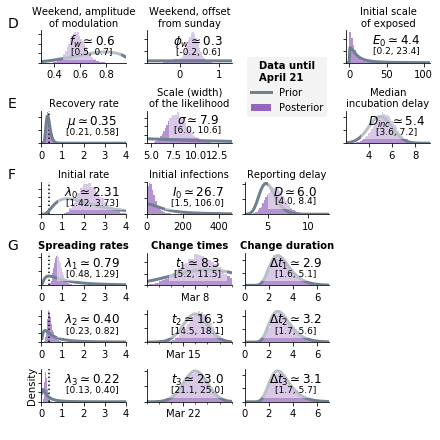

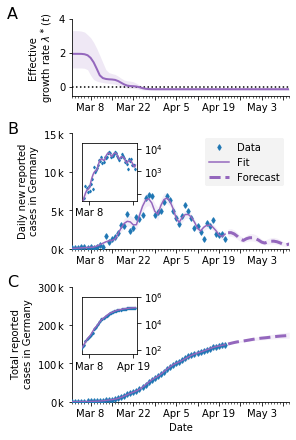

In [8]:
create_figure_distributions(model, trace,
                            additional_insets = {'E_begin_scale': r"$E_0 \simeq ",
                                                 'median_incubation': r"$D_{inc} \simeq "}, 
                            xlim_lambda = (0, 4), color = 'tab:purple',
                            num_changepoints=3, save_to=path_to_save + 'Fig_SEIR_distr')
create_figure_timeseries(trace, 'tab:purple', num_days_futu_to_plot=21, y_lim_lambda = (-0.5, 4),
                       plot_red_axis=False, save_to=path_to_save + 'Fig_SEIR_cases')

In [13]:
print(pm.loo(trace, model))

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   782.04    16.86
p_loo     10.71        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       51  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [31]:
for j in range(4):
    print(f'lambda* {j}')   
    print(print_median_CI(trace[f"lambda_{j}"] - trace.mu, prec=2))

lambda* 0
Median: 1.95
CI: [1.12, 3.30]
lambda* 1
Median: 0.45
CI: [0.16, 0.80]
lambda* 2
Median: 0.05
CI: [-0.09, 0.36]
lambda* 3
Median: -0.12
CI: [-0.20, -0.08]
